In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Imports

In [3]:
import os
import warnings
import pickle
import pysam
import numpy as np
from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *
from keras.models import load_model
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1
from keras.models import load_model
from kerasAC.metrics import recall, specificity, fpr, fnr, precision, f1
from kerasAC.custom_losses import ambig_binary_crossentropy, ambig_mean_squared_error

Using TensorFlow backend.
W1022 08:26:46.168489 139787980424960 deprecation_wrapper.py:119] From /users/annashch/miniconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## Select GPU

In [4]:
warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
!env | grep "CUDA"

CUDA_VISIBLE_DEVICES=1
CUDA_HOME=/usr/local/cuda-10.0


## Get Model (Regression)

In [4]:
model_string_gc="DNASE.K562.regressionlabels.7.withgc"
model_string="DNASE.K562.regressionlabels.allbins.7"

##load the model 
custom_objects={"recall":recall,
                "sensitivity":recall,
                "specificity":specificity,
                "fpr":fpr,
                "fnr":fnr,
                "precision":precision,
                "f1":f1,
                "ambig_binary_crossentropy":ambig_binary_crossentropy,
                "ambig_mean_squared_error":ambig_mean_squared_error}
model_gc=load_model(model_string_gc,custom_objects=custom_objects)
model=load_model(model_string,custom_objects=custom_objects)

W1022 08:26:51.153646 139787980424960 deprecation_wrapper.py:119] From /users/annashch/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1022 08:26:51.164071 139787980424960 deprecation_wrapper.py:119] From /users/annashch/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1022 08:26:51.192085 139787980424960 deprecation_wrapper.py:119] From /users/annashch/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1022 08:26:51.193155 139787980424960 deprecation_wrapper.py:119] From /users/annashch/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.

## Iterate through the loci  

In [31]:
gc_content=open("../compute_gc/gc.HBA2.bed",'r').read().strip().split('\n')
gc_vals=np.expand_dims(np.asarray([float(i.split('\t')[-1]) for i in gc_content]),axis=1)



In [32]:
import pandas as pd
def get_seq_centered_at_summit(fname,flank):
    data=pd.read_csv(fname,header=None,sep='\t')
    data['chrom']=data[0]
    data['center']=[int(round(i)) for i in (data[1]+data[2])]
    data['start']=data['center']-flank
    data['end']=data['center']+flank
    subset=data[['chrom','start','end']]
    inputs=[]
    for index,row in subset.iterrows(): 
        inputs.append((row['chrom'],row['start'],row['end']))
    return inputs

In [33]:
from dragonn.utils import * 
import pandas as pd 
flank=500
ref_fasta="/users/annashch/male.hg19.fa"
bed=get_seq_centered_at_summit("../coordinates/Gurkan_hg19_loci_coords/HBA2.geneLocus.250bp.windows.hg19.bed",flank)


In [34]:
len(bed)

4652

In [35]:
len(gc_vals)

4652

In [36]:
onehot_seq=one_hot_from_bed(bed,ref_fasta)

In [37]:
print(onehot_seq.shape)
print(gc_vals.shape)

(4652, 1, 1000, 4)
(4652, 1)


In [38]:
print(model.layers[-1].output)
print(model_gc.layers[-1].output)


Tensor("dense_24/BiasAdd:0", shape=(?, 1), dtype=float32)
Tensor("dense_3_1/BiasAdd:0", shape=(?, 1), dtype=float32)


In [39]:
model_gc.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 1000, 4)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 1000, 300) 23100       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1, 1000, 300) 1200        conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 1, 1000, 300) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [40]:
from keras import backend as K
target_layer_idx=-1
fn = K.function(model.inputs, K.gradients(model.layers[target_layer_idx].output, model.inputs))
fn_gc = K.function(model_gc.inputs, K.gradients(model_gc.layers[target_layer_idx].output, model_gc.inputs))



In [42]:
grads_gc=fn_gc([onehot_seq,gc_vals])[0] #only w/respect to sequence input 

In [43]:
grads=fn([onehot_seq])[0] #only w/respect to sequence input 


In [44]:
## get the gkmexplain scores for HBA2
gkmexplain_path="/mnt/lab_data2/annashch/locusselect_examples/dataForGurkan/locusselect_data_for_Gurkan/gkm_explain/gkm_explain_HBA2.txt"
gkmexplain_scores=pd.read_csv(gkmexplain_path,header=None,sep='\t')

In [50]:
gkmexplain_scores.head()

,0,1,2
0,chr16:60000-60250,-0.792917,"0.0,0.0,0.0,0.0007394645;0.0014005290000000002..."
1,chr16:60250-60500,-0.398114,"0.0,0.0,0.0,0.000840039875;0.0,0.0,0.0,0.00157..."
2,chr16:60500-60750,0.909268,"0.0,0.0,-0.00036399993750000004,0.0;0.00140679..."
3,chr16:60750-61000,1.013656,"0.0,0.0,-0.0007218375000000001,0.0;0.0,0.0,-0...."
4,chr16:61000-61250,-0.313017,"0.0,0.0,0.0,0.000127029875;0.0,0.0,0.0,0.00177..."


In [54]:
## get the top 5 scoring loci. 
gkmexplain_sorted=gkmexplain_scores.sort_values(by=1, ascending=False)
gkmexplain_sorted.head()

,0,1,2
414,chr16:163500-163750,2.117760,"0.0,0.000605946625,0.0,0.0;0.0,0.0,0.0,0.00113..."
2508,chr16:687000-687250,1.981784,"0.0,3.8962212499999995e-05,0.0,0.0;0.0,0.0,-0...."
1371,chr16:402750-403000,1.798819,"0.0,0.0,-0.00046547375000000003,0.0;-0.0019482..."
576,chr16:204000-204250,1.700254,"-0.0003600102,0.0,0.0,0.0;0.0,-0.00047431825,0..."
3096,chr16:834000-834250,1.668971,"0.0,0.0,0.0007725190000000002,0.0;0.0,0.0,0.0,..."


In [100]:
def get_gkmexplain_array(score_string): 
    final_array=[]
    pos_array=score_string.split(';')
    for pos in pos_array: 
        base_array=[float(i) for i in pos.split(',')]
        final_array.append(base_array)
    return np.expand_dims(np.expand_dims(np.asarray(final_array),axis=0),axis=0)

In [101]:
gkm_row=get_gkmexplain_array(gkmexplain_sorted.iloc[414][2])

In [112]:
np.sum(gkm_row)

1.12431526225875

In [23]:
## make bedgraph for caprin tiled 
'''
out_bedgraph=open('caprin.grads.with.gc.hg38.regression.bedGraph','w')
for i in range(len(caprin_tiled)): 
    cur_chrom=caprin_tiled[i][0]
    cur_start=caprin_tiled[i][1]
    cur_grad_track=grads_tiled[i].squeeze() 
    num_entries=cur_grad_track.shape[0]
    for j in range(num_entries): 
        cur_grad=cur_grad_track[j].sum() 
        out_bedgraph.write(cur_chrom+'\t'+str(cur_start+j)+'\t'+str(cur_start+j+1)+'\t'+str(cur_grad)+'\n')
'''

"\nout_bedgraph=open('caprin.grads.with.gc.hg38.regression.bedGraph','w')\nfor i in range(len(caprin_tiled)): \n    cur_chrom=caprin_tiled[i][0]\n    cur_start=caprin_tiled[i][1]\n    cur_grad_track=grads_tiled[i].squeeze() \n    num_entries=cur_grad_track.shape[0]\n    for j in range(num_entries): \n        cur_grad=cur_grad_track[j].sum() \n        out_bedgraph.write(cur_chrom+'\t'+str(cur_start+j)+'\t'+str(cur_start+j+1)+'\t'+str(cur_grad)+'\n')\n"

In [45]:
grads.shape

(4652, 1, 1000, 4)

In [46]:
grads_gc.shape

(4652, 1, 1000, 4)

In [47]:
np.savez_compressed("HBA2.uncorrected.regression.grads.npz",grads=grads)

In [48]:
np.savez_compressed("HBA2.gc.corrected.regression.grads.npz",grads_gc=grads_gc)

In [107]:
def plot_seq_importance(gkmexplain_vals,grads,grads_gc, x, xlim=None, ylim=None, figsize=(25, 6),title="",snp_pos=0,axes=None):
    """Plot  sequence importance score                                                                                                                                                                                                                                 
                                                                                                                                                                                                                                                                       
    Args:                                                                                                                                                                                                                                                              
      grads: either deeplift or gradientxinput score matrix                                                                                                                                                                                                            
      x: one-hot encoded DNA sequence                                                                                                                                                                                                                                  
      xlim: restrict the plotted xrange                                                                                                                                                                                                                                
      figsize: matplotlib figure size                                                                                                                                                                                                                                  
    """
    if axes is None:
        f,axes=plt.subplots(3,dpi=80,figsize=figsize)
        show=True
    else:
        show=False
    gkmexplain_vals=gkmexplain_vals.squeeze()
    grads=grads.squeeze()
    grads_gc=grads_gc.squeeze() 
    x=x.squeeze()
    
    seq_len = x.shape[0]
    vals_to_plot_gkm=gkmexplain_vals*x
    vals_to_plot=grads*x
    vals_to_plot_gc=grads_gc*x
   
    if ylim is None:
        ylim_gkm=(np.amin(vals_to_plot_gkm),np.amax(vals_to_plot_gkm))
        ylim= (np.amin(vals_to_plot),np.amax(vals_to_plot))
        ylim_gc=(np.amin(vals_to_plot_gc),np.amax(vals_to_plot_gc))
        ylim_min=min([ylim_gkm[0], ylim[0], ylim_gc[0]])
        ylim_max=max([ylim_gkm[1], ylim[1], ylim_gc[1]])
        ylim=(ylim_min,ylim_max)
    
    axes[0]=plot_bases_on_ax(vals_to_plot_gkm,axes[0],show_ticks=True)
    axes[1]=plot_bases_on_ax(vals_to_plot,axes[1],show_ticks=True)
    axes[2]=plot_bases_on_ax(vals_to_plot_gc,axes[2],show_ticks=True)
    axes[0].set_xlim(xlim)
    axes[0].set_ylim(ylim)
    axes[1].set_xlim(xlim)
    axes[1].set_ylim(ylim)
    axes[2].set_xlim(xlim)
    axes[2].set_ylim(ylim)
    axes[0].set_title("gkmexplain."+title)
    axes[1].set_title(title)
    axes[2].set_title("gc.corrected."+title)
    axes[0].axvline(x=snp_pos, color='k', linestyle='--')
    axes[1].axvline(x=snp_pos, color='k', linestyle='--')
    axes[2].axvline(x=snp_pos, color='k', linestyle='--')
    plt.subplots_adjust(hspace=0.4)
    if show==True:
        plt.savefig(title+'.png',dpi=300)
        plt.show()
    else:
        return axes


In [105]:
list(gkmexplain_sorted.index[0:5])

[414, 2508, 1371, 576, 3096]

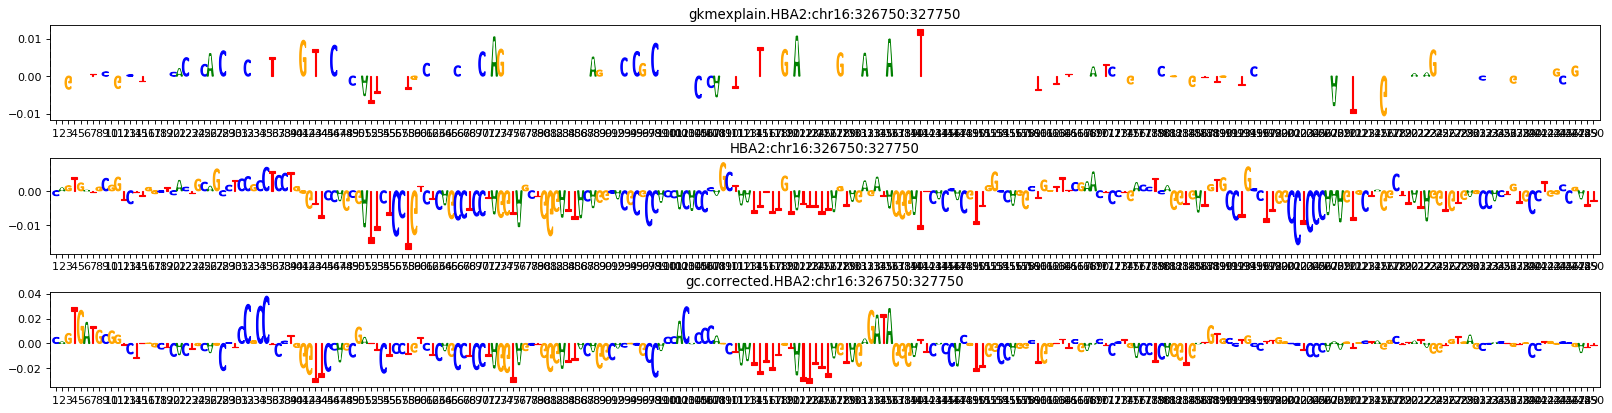

None
414


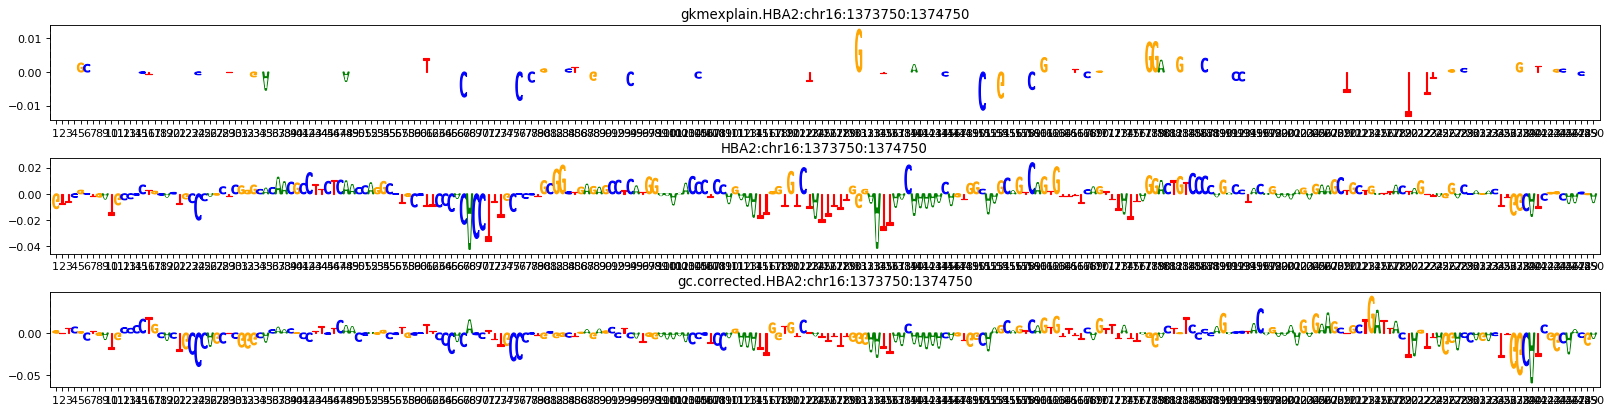

None
2508


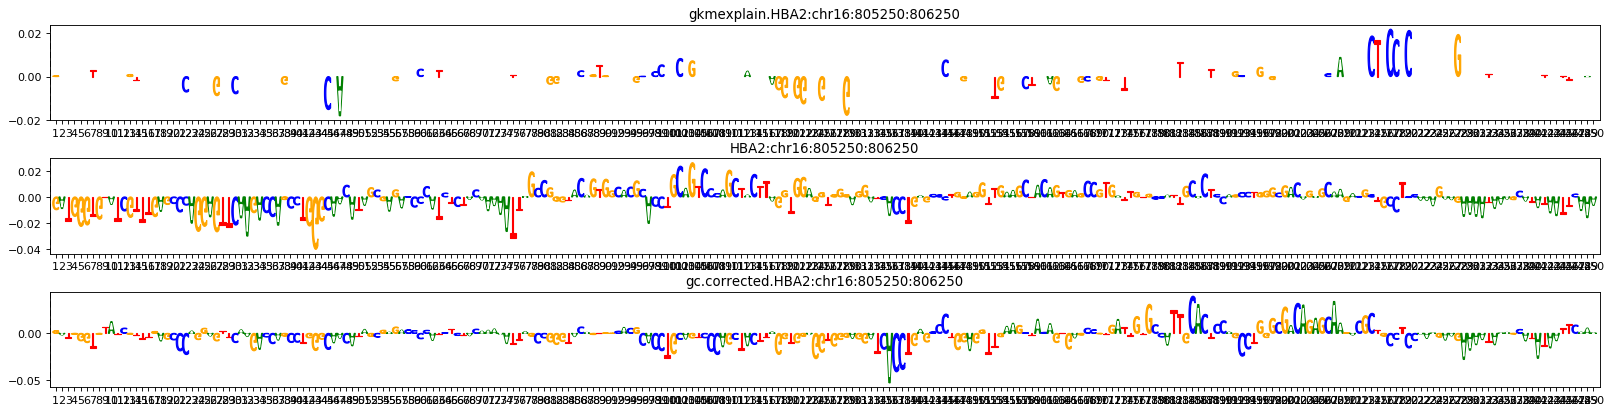

None
1371


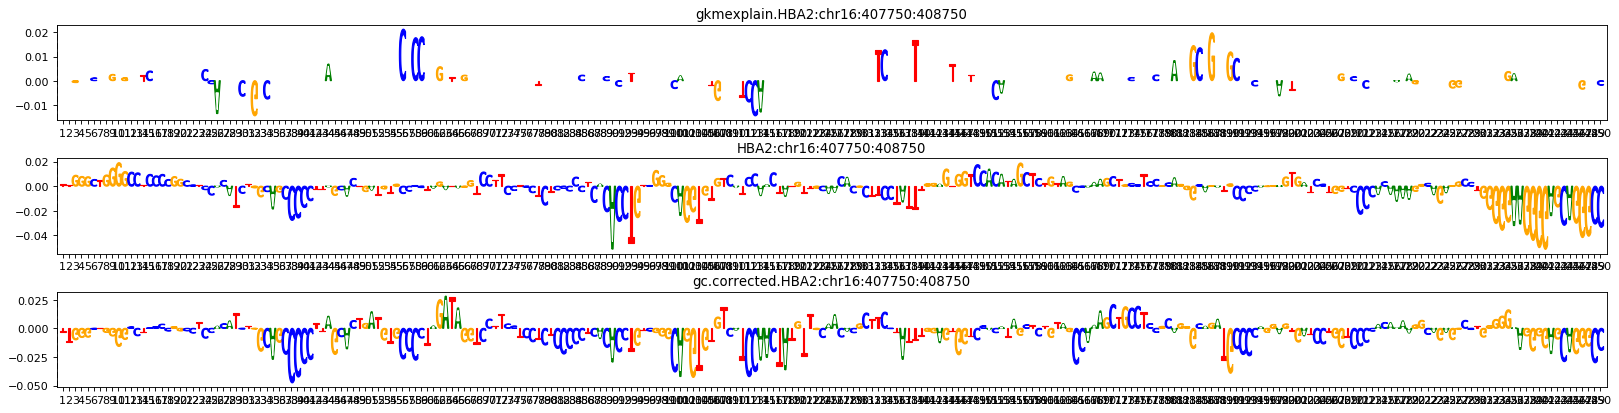

None
576


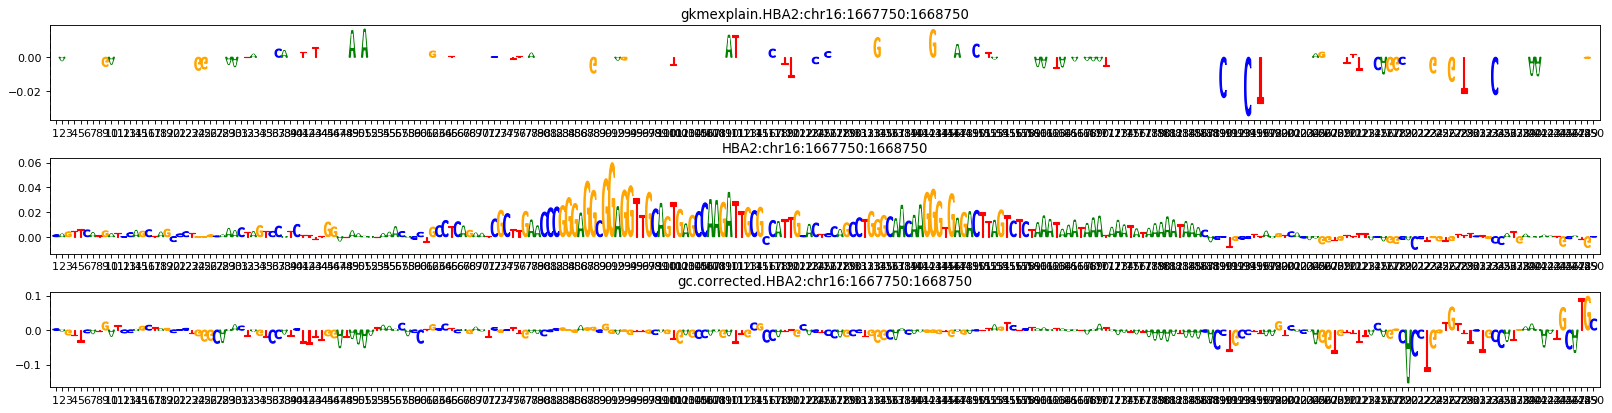

None
3096


In [106]:
for i in list(gkmexplain_sorted.index[0:5]):
    cur_title='HBA2:'+':'.join([str(j) for j in bed[i]])
    gkmexplain_vals=get_gkmexplain_array(gkmexplain_sorted.iloc[i][2])
    print(plot_seq_importance(gkmexplain_vals,
                        grads[i,:,375:625,:],
                        grads_gc[i,:,375:625,:],
                        onehot_seq[i,:,375:625,:],
                        title=cur_title))
    print(i)

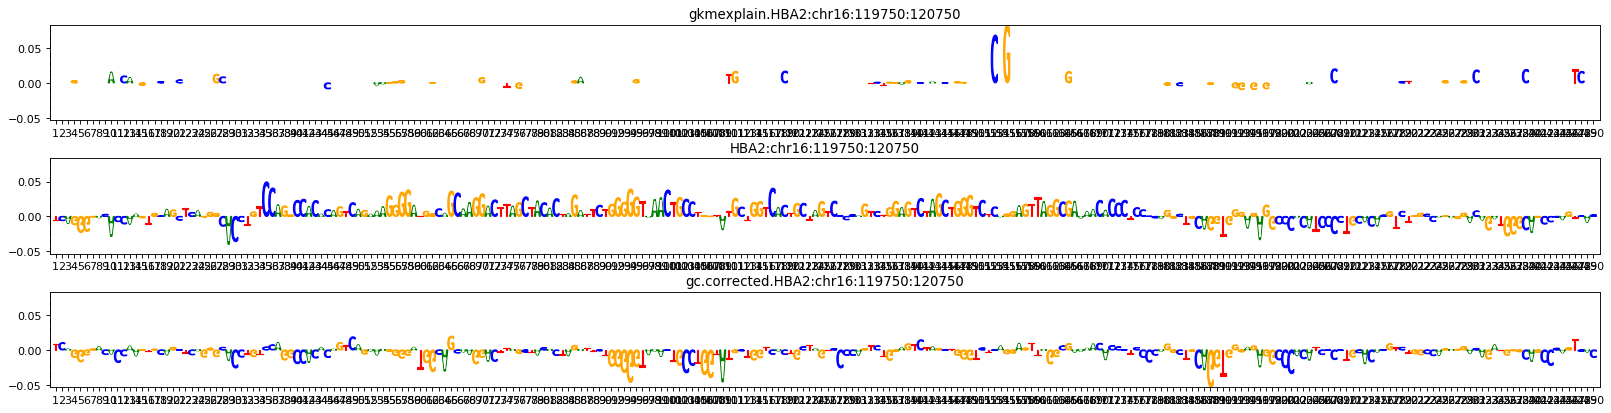

None
0


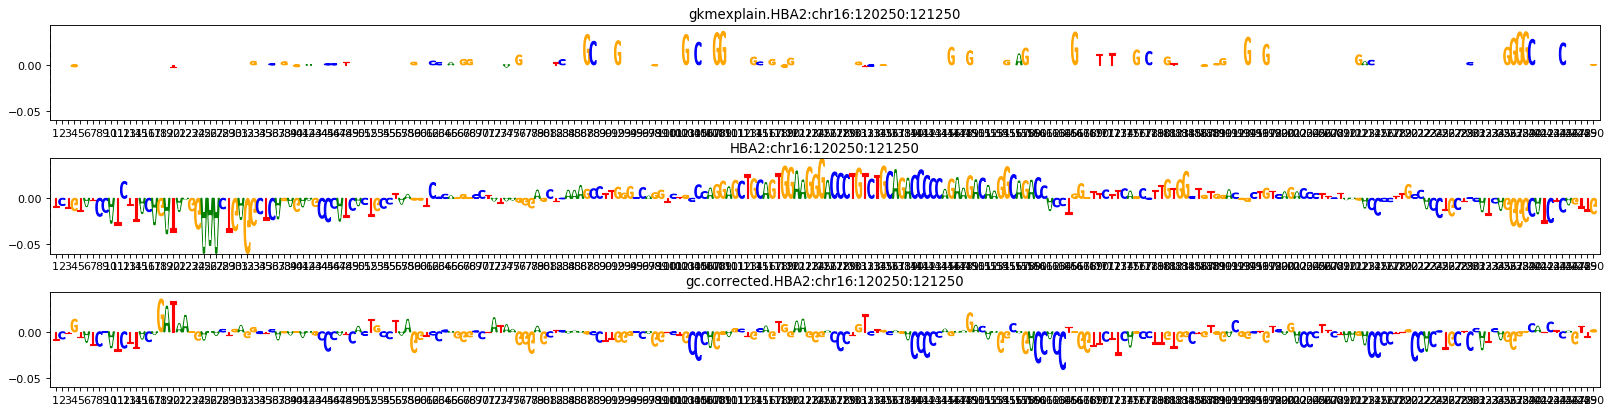

None
1


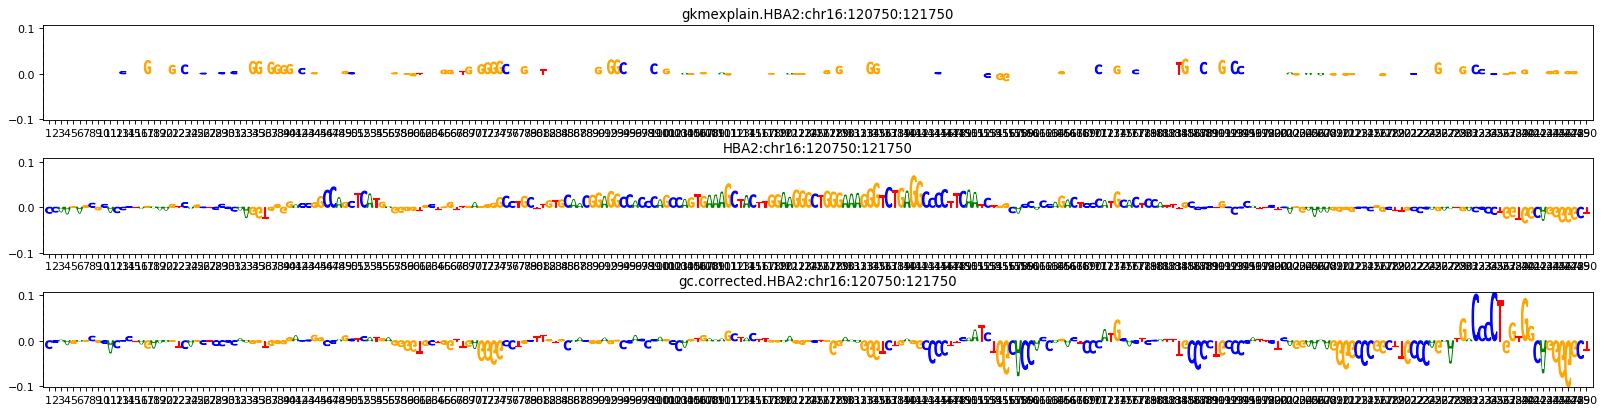

None
2


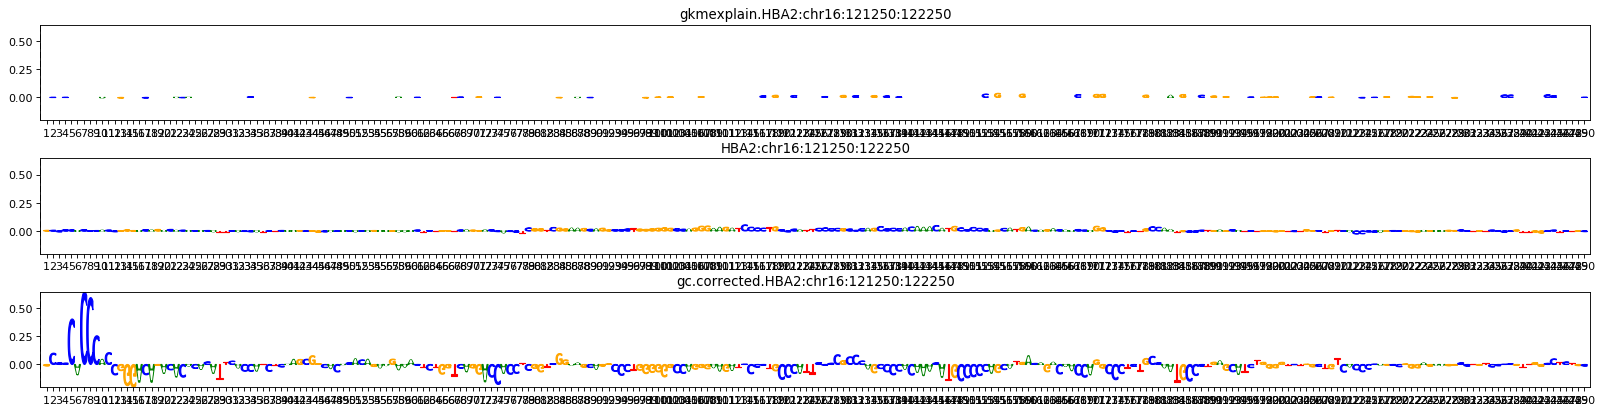

None
3


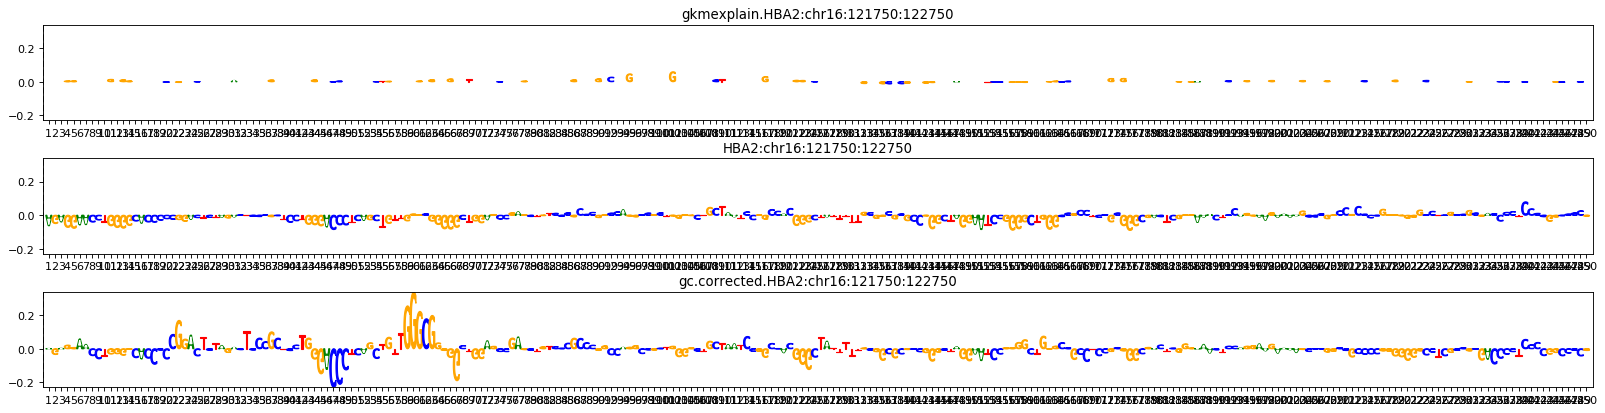

None
4


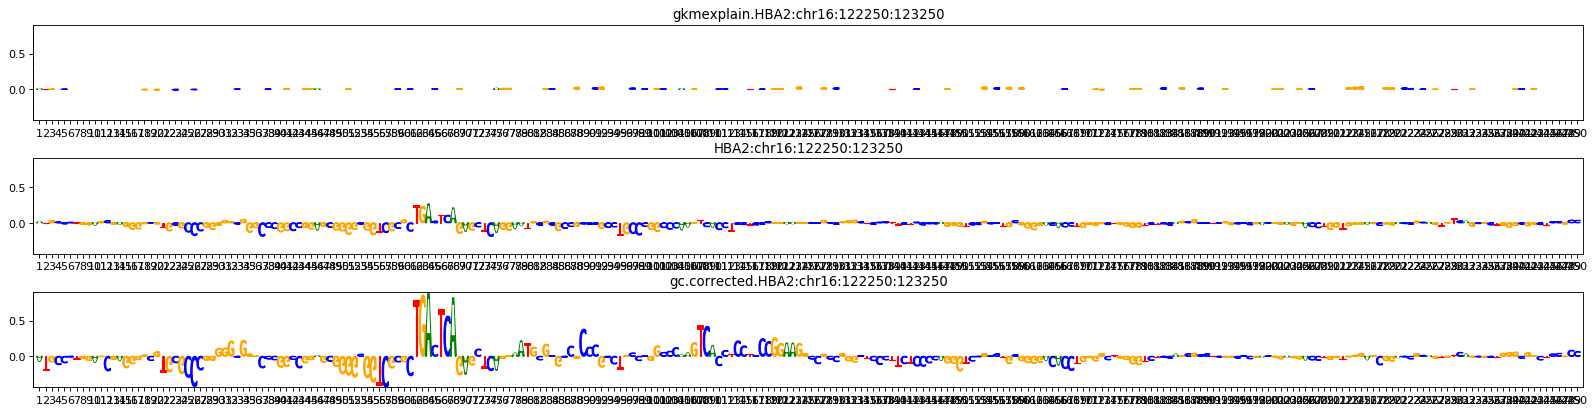

None
5


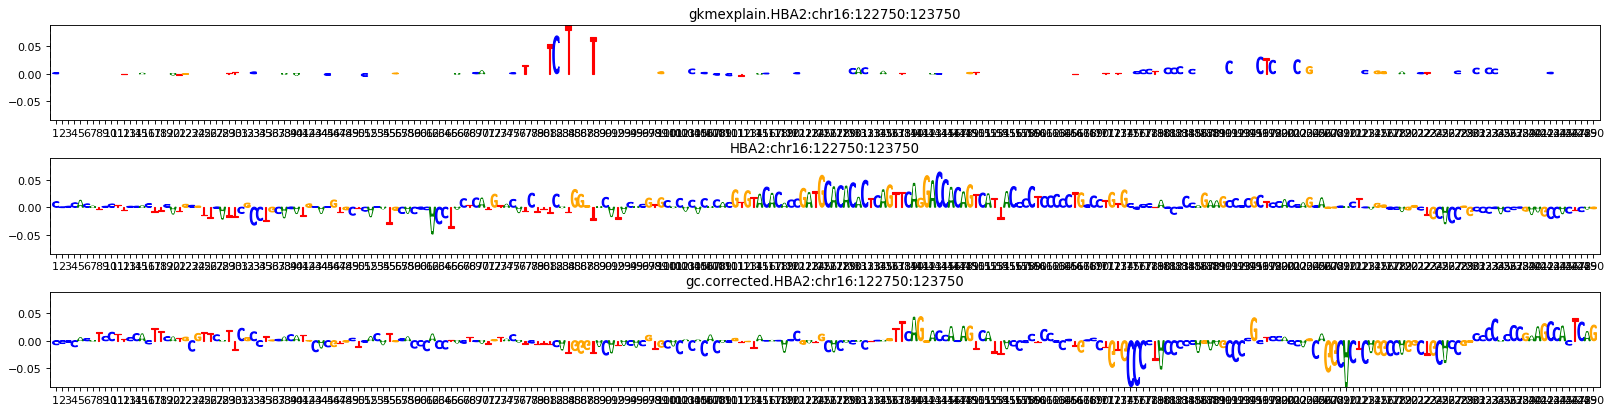

None
6


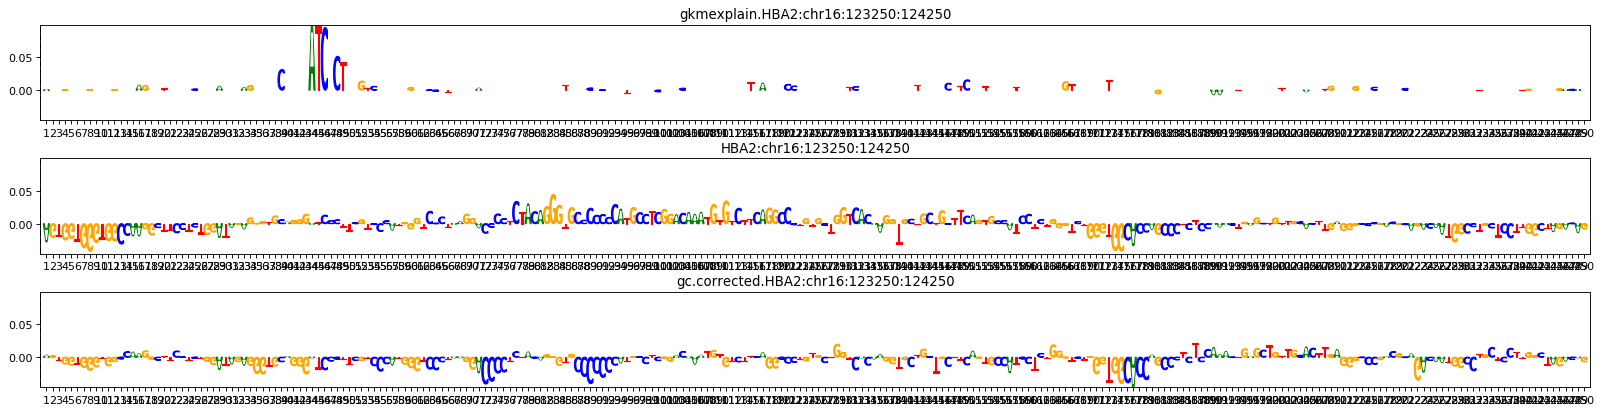

None
7


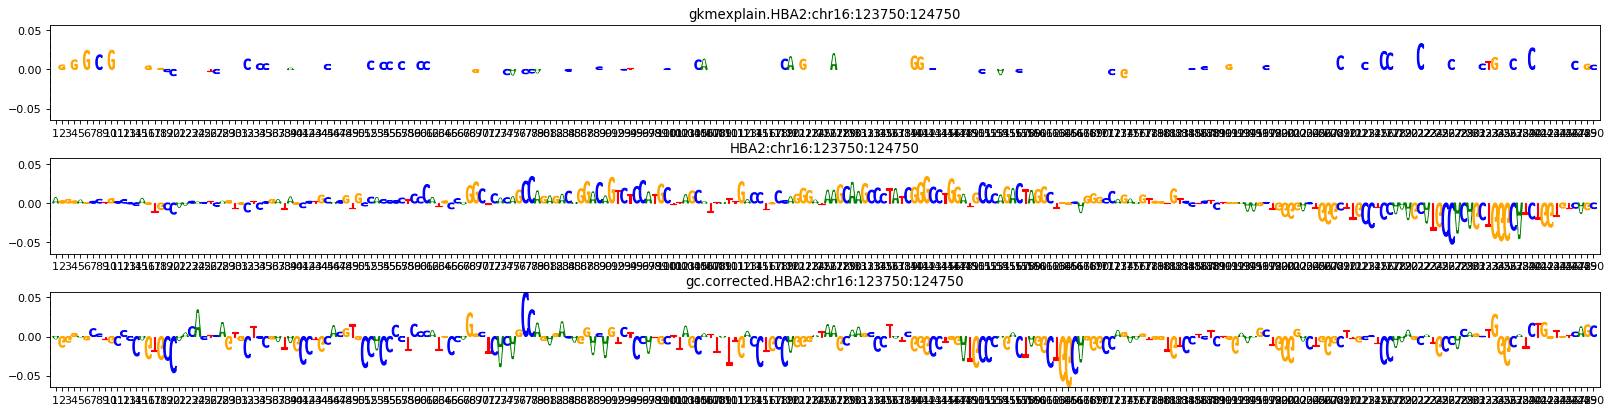

None
8


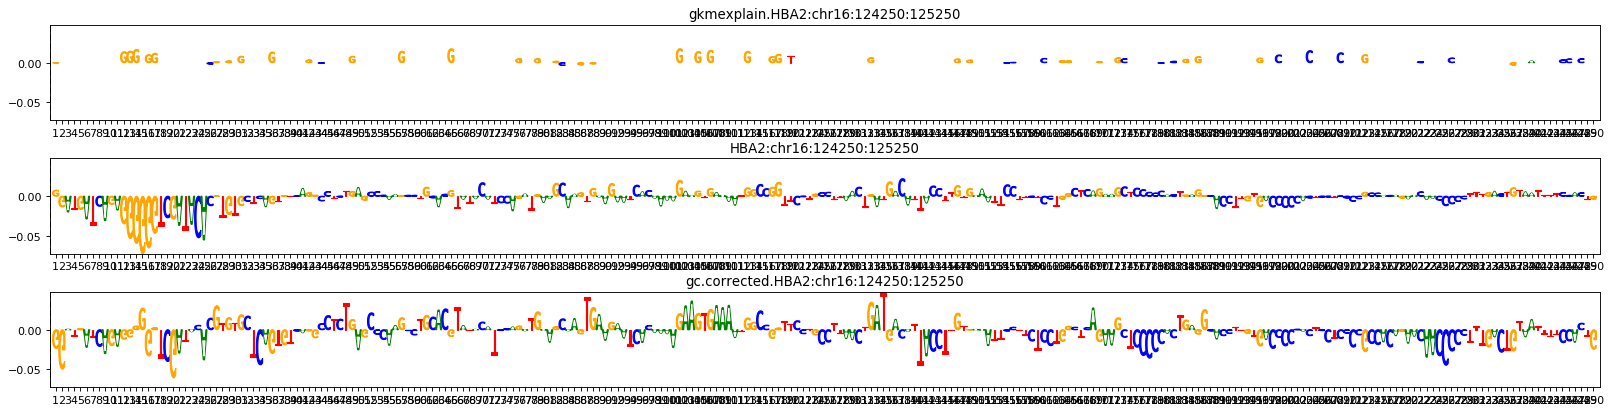

None
9


In [108]:
for i in range(10):
    cur_title='HBA2:'+':'.join([str(j) for j in bed[i]])
    gkmexplain_vals=get_gkmexplain_array(gkmexplain_sorted.iloc[i][2])
    print(plot_seq_importance(gkmexplain_vals,
                        grads[i,:,375:625,:],
                        grads_gc[i,:,375:625,:],
                        onehot_seq[i,:,375:625,:],
                        title=cur_title))
    print(i)